In [1]:
!pip install detoxify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.2 MB/s 
     |████████████████████████████████| 5.5 MB 40.2 MB/s 
     |████████████████████████████████| 182 kB 54.6 MB/s 
     |████████████████████████████████| 7.6 MB 40.8 MB/s 


In [1]:
from detoxify import Detoxify
import pandas as pd
from tqdm import tqdm

In [ ]:
toxiticy_model = Detoxify('multilingual')

In [3]:
data = pd.read_csv('../data/batches.csv')

In [4]:
batches = []
for b in set(data.batch.to_numpy()):
    batches.append(data.query(f'batch == {b}'))

In [5]:
n = len(batches)
print(f'Running for {n} batches')
for i,batch in enumerate(tqdm(batches)):
    print(f'Running for batch {i}')
    sentences = batch.sentence.to_list()
    batch = batch.assign(
        bert_toxicity=toxiticy_model.predict(sentences)['toxicity']
        )
    n_batch = batch.batch.unique()[0]
    batch.to_csv(f'../data/bert_toxicity_classification_{n_batch}.csv', index=False)

Running for 30 batches


  0%|          | 0/30 [00:00<?, ?it/s]

Running for batch 0


  3%|▎         | 1/30 [02:47<1:20:47, 167.14s/it]

Running for batch 1


  7%|▋         | 2/30 [04:36<1:02:04, 133.03s/it]

Running for batch 2


 10%|█         | 3/30 [07:00<1:02:04, 137.96s/it]

Running for batch 3


 13%|█▎        | 4/30 [08:58<56:22, 130.11s/it]  

Running for batch 4


 17%|█▋        | 5/30 [11:25<56:48, 136.35s/it]

Running for batch 5


 20%|██        | 6/30 [13:24<52:06, 130.28s/it]

Running for batch 6


 23%|██▎       | 7/30 [15:16<47:45, 124.57s/it]

Running for batch 7


 27%|██▋       | 8/30 [17:45<48:26, 132.10s/it]

Running for batch 8


 30%|███       | 9/30 [19:34<43:41, 124.85s/it]

Running for batch 9


 33%|███▎      | 10/30 [21:11<38:48, 116.41s/it]

Running for batch 10


 37%|███▋      | 11/30 [23:47<40:41, 128.52s/it]

Running for batch 11


 40%|████      | 12/30 [26:05<39:27, 131.51s/it]

Running for batch 12


 43%|████▎     | 13/30 [28:29<38:20, 135.31s/it]

Running for batch 13


 47%|████▋     | 14/30 [30:33<35:09, 131.82s/it]

Running for batch 14


 50%|█████     | 15/30 [32:35<32:12, 128.81s/it]

Running for batch 15


 53%|█████▎    | 16/30 [35:16<32:19, 138.52s/it]

Running for batch 16


 57%|█████▋    | 17/30 [37:39<30:18, 139.91s/it]

Running for batch 17


 60%|██████    | 18/30 [39:44<27:04, 135.35s/it]

Running for batch 18


 63%|██████▎   | 19/30 [41:59<24:46, 135.09s/it]

Running for batch 19


 67%|██████▋   | 20/30 [44:07<22:12, 133.22s/it]

Running for batch 20


 70%|███████   | 21/30 [47:08<22:06, 147.34s/it]

Running for batch 21


 73%|███████▎  | 22/30 [49:34<19:35, 146.91s/it]

Running for batch 22


 77%|███████▋  | 23/30 [51:18<15:39, 134.28s/it]

Running for batch 23


 80%|████████  | 24/30 [52:51<12:10, 121.77s/it]

Running for batch 24


 83%|████████▎ | 25/30 [55:03<10:24, 125.00s/it]

Running for batch 25


 87%|████████▋ | 26/30 [56:49<07:56, 119.06s/it]

Running for batch 26


 90%|█████████ | 27/30 [58:59<06:07, 122.54s/it]

Running for batch 27


 93%|█████████▎| 28/30 [1:02:23<04:53, 146.90s/it]

Running for batch 28


 97%|█████████▋| 29/30 [1:04:40<02:24, 144.01s/it]

Running for batch 29


100%|██████████| 30/30 [1:07:38<00:00, 135.27s/it]


In [6]:
from glob import glob

In [7]:
files = glob('../data/bert_toxicity_classification_*')
all_toxicity = pd.concat([pd.read_csv(file_) for file_ in files])

In [8]:
all_toxicity.to_csv('../data/bert_toxicity_classification.csv', index=False)

# Comparisson against Perspective API

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
bert_toxicity = pd.read_csv('../data/bert_toxicity_classification.csv')
original_sentences = bert_toxicity.loc[
    bert_toxicity.variable == 'original_sentence']
modified_sentences = bert_toxicity.loc[
    bert_toxicity.variable != 'original_sentence']
original_sentences = original_sentences.filter(
    ['original', 'bert_toxicity']).rename(columns={'bert_toxicity':'original_toxicity'})

comparative_toxicity = pd.pivot(
    modified_sentences, 
    index=['op_gender', 'subreddit', 'original', 'category'],
    columns=['variable'],
    values=['sentence', 'bert_toxicity']
    ).reset_index()

In [4]:
col_names = []
for col in comparative_toxicity.columns:
    if col[0] == 'bert_toxicity':
        col_name = col[1] + '_'+ col[0]
    elif col[0] == 'sentence':
        col_name = col[1]
    else:
        col_name = col[0]
    col_names.append(col_name)

comparative_toxicity.columns = col_names
comparative_toxicity = comparative_toxicity.merge(
    original_sentences,
    on='original'
)

In [5]:
perspective_toxicity = pd.read_csv('../data/toxicity_classification.csv')

In [6]:
bert_toxicity = comparative_toxicity.assign(
    score_diff_recommended_bert =comparative_toxicity.recommended_sentence_bert_toxicity - comparative_toxicity.original_toxicity,
    score_diff_not_recommended_bert = comparative_toxicity.non_recommended_sentence_bert_toxicity - comparative_toxicity.original_toxicity
)
perspective_toxicity = perspective_toxicity.assign(
    score_diff_recommended_persp = perspective_toxicity.recommended_sentence_toxicity_score - perspective_toxicity.original_toxicity,
    score_diff_not_recommended_persp = perspective_toxicity.non_recommended_sentence_toxicity_score - perspective_toxicity.original_toxicity
)

In [7]:
perspective_toxicity = perspective_toxicity.loc[
    :,[
        'original', 'category', 
        'non_recommended_sentence', 'recommended_sentence',
        'score_diff_recommended_persp', 'score_diff_not_recommended_persp'
        ]]

In [8]:
bert_toxicity = bert_toxicity.loc[
    :,[
        'original', 'category', 
        'non_recommended_sentence', 'recommended_sentence',
        'score_diff_recommended_bert', 'score_diff_not_recommended_bert'
        ]]
all_toxicity = perspective_toxicity.merge(
    bert_toxicity,
    on=[
        'original', 'category', 
        'non_recommended_sentence', 'recommended_sentence']
)

In [9]:
print('-'*4+' Perspective Results:')
print('non rec:{}'.format(all_toxicity.score_diff_not_recommended_persp.mean()))
print('rec:{}'.format(all_toxicity.score_diff_recommended_persp.mean()))

print('-'*4+' Bert Results:')
print('non rec:{}'.format(all_toxicity.score_diff_not_recommended_bert.mean()))
print('rec:{}'.format(all_toxicity.score_diff_recommended_bert.mean()))

---- Perspective Results:
non rec:0.13358023805388455
rec:0.09622199889300005
---- Bert Results:
non rec:0.13828778356793023
rec:0.01887166542729224


In [10]:
variable_name_map = {
    'score_diff_recommended_persp': 'recommended',
    'score_diff_not_recommended_persp': 'not recommended'
}
toxicity_plot = all_toxicity.melt(id_vars=['category'], value_vars=['score_diff_recommended_persp', 'score_diff_not_recommended_persp'])
toxicity_plot['variable'] = toxicity_plot.variable.map(variable_name_map)

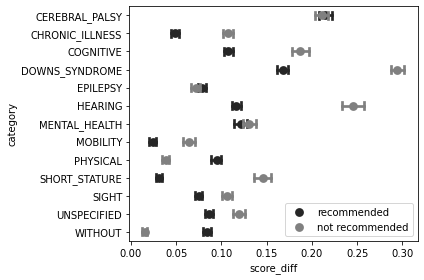

In [11]:
fig, ax = plt.subplots()
sns.pointplot(
    data=toxicity_plot, x="value", y="category", hue='variable',
    errorbar=("ci", 95), capsize=.4, join=False, color=".5",
)
plt.legend(title='')
plt.xlabel('score_diff')
fig.tight_layout()
plt.savefig('../data/score_diff_perspective.png')

In [12]:
variable_name_map = {
    'score_diff_recommended_bert': 'recommended',
    'score_diff_not_recommended_bert': 'not recommended'
}
toxicity_plot = all_toxicity.melt(id_vars=['category'], value_vars=['score_diff_recommended_bert', 'score_diff_not_recommended_bert'])
toxicity_plot['variable'] = toxicity_plot.variable.map(variable_name_map)

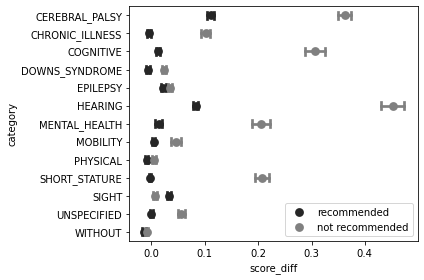

In [13]:
fig, ax = plt.subplots()
sns.pointplot(
    data=toxicity_plot, x="value", y="category", hue='variable',
    errorbar=("ci", 95), capsize=.4, join=False, color=".5",
)
plt.legend(title='')
plt.xlabel('score_diff')
fig.tight_layout()
plt.savefig('../data/score_diff_bert.png')